### Bo's Dataset and Toronto Centrelines
This file loads Bo's dataset/shapefile for cycling stress classification:<br>
(https://github.com/lin-bo/Toronto_LTS_network) <br>
It also loads in Toronto road shapefile taken from Toronto's Open Data Portal: <br>
(https://open.toronto.ca/dataset/neighbourhood-profiles/) <br>
(https://open.toronto.ca/dataset/neighbourhoods/) <br>

Work performed:
- load data (shapefile and Bo's LTS data targets).
- perform EDA to see if the road type could be used as a feature. Use dummy encoding.

#### Imports:

In [23]:
# Import 3rd party libraries
import os
import json
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

# Configure Notebook
%matplotlib inline
#plt.style.use('dark_background')
plt.style.use('seaborn-colorblind')
#plt.style.use('ggplot')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

#### Import the raw data into a dataframe
Import both Bo's data and the centrelines with corresponding feature names

(59554, 12)


<AxesSubplot:>

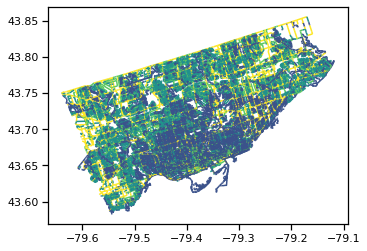

In [24]:
# import Bo's shapefile
file_path_keagan = 'C:/Users/Keagan Rankin/Documents/PycharmProj/data/raw_data/Bo Github Data/centerline_LTS_July2021.shp'
file_path_saad = 'insert here for ease'
lts_gpd = gpd.read_file(file_path_keagan)
print(lts_gpd.shape)
lts_gpd.plot(column='LTS')

In [25]:
#Import the shapefile from open Toronto (see eda_toronto_centrelines)
geojsonpath = 'C:/Users/keaga/PycharmProjects/1498-ML-Project/data/raw_data/centreline_wgs84_geojson_v2/CENTRELINE_WGS84.geojson'
path2 = 'C:/Users/Keagan Rankin/Documents/PycharmProj/data/raw_data/centreline_wgs84_geojson_v2/CENTRELINE_WGS84.geojson'
centrelines_gpd = gpd.read_file(path2)

centrelines_gpd.head()

,CENTRELINE_ID,LINEAR_NAME_ID,LINEAR_NAME_FULL,LINEAR_NAME_FULL_LEGAL,ADDRESS_L,ADDRESS_R,PARITY_L,PARITY_R,LO_NUM_L,HI_NUM_L,...,ONEWAY_DIR_CODE,ONEWAY_DIR_CODE_DESC,FEATURE_CODE,FEATURE_CODE_DESC,JURISDICTION,CENTRELINE_STATUS,OBJECTID,MI_PRINX,Shape__Length,geometry
0,14646677,4807,Antibes Dr,Antibes Drive,None,None,N,N,NaN,NaN,...,0,Not One-Way,201400,Collector,CITY OF TORONTO,None,419,419,3.922905,"LINESTRING (-79.45043 43.78194, -79.45039 43.7..."
1,14257954,11624,427 X S Gardiner X E Ramp,427 X S Gardiner X E Ramp,None,None,N,N,NaN,NaN,...,1,Follow-Digitization,201101,Expressway Ramp,PROVINCE,None,617,617,4.056786,"LINESTRING (-79.54894 43.61345, -79.54890 43.6..."
2,20079785,9580,Planning Boundary,Planning Boundary,None,None,N,N,NaN,NaN,...,0,Not One-Way,207001,Geostatistical line,CITY OF TORONTO,None,813,813,2.601053,"LINESTRING (-79.43889 43.64789, -79.43891 43.6..."
3,13969361,1892,Keane Ave,Keane Avenue,None,76-76,N,E,NaN,NaN,...,0,Not One-Way,201500,Local,CITY OF TORONTO,None,1460,1460,7.043388,"LINESTRING (-79.56017 43.64864, -79.56023 43.6..."
4,20054901,18818,Ww W Kennedy W Jade,Ww W Kennedy W Jade,None,None,N,N,NaN,NaN,...,0,Not One-Way,204002,Walkway,CITY OF TORONTO,None,1654,1654,4.935282,"LINESTRING (-79.29153 43.78104, -79.29157 43.7..."


In [26]:
centrelines_gpd = centrelines_gpd[['CENTRELINE_ID', 'FEATURE_CODE', 'FEATURE_CODE_DESC', 'JURISDICTION','LINEAR_NAME_FULL','geometry']]

#### Join centrelines to Bo's raod segments
WE need ot find the corresponding ID tag to join them, <br>
and we really only need to join the 'FEATURE_CODE' and 'FEATURE_CODE_DESC' <br>
Bo's README.md on github says you can join on 'GEO_ID' in lts_gpd

In [27]:
print(lts_gpd['GEO_ID'].min())
lts_gpd['GEO_ID'].head()

108


0    30079678
1    30079680
2    30079677
3    30082310
4    30008940
Name: GEO_ID, dtype: int64

In [28]:
centrelines_gpd['CENTRELINE_ID'].head()

0    14646677
1    14257954
2    20079785
3    13969361
4    20054901
Name: CENTRELINE_ID, dtype: int64

In [48]:
# Join the two dataframes by attribute join -> just use pandas merge
centrelines_metre = centrelines_gpd.to_crs("EPSG:26917")
lts_metre = lts_gpd.to_crs("EPSG:26917")

centre_merge = pd.merge(lts_metre, #left
                        centrelines_metre, #right
                        how='left',
                        left_on='GEO_ID',
                        right_on='CENTRELINE_ID',
                       )

print(centre_merge.shape)
centre_merge.head()

(59554, 18)


,OBJECTID,GEO_ID,LFN_ID,LF_NAME,FNODE,TNODE,ONE_WAY_DI,length_in_,GEO_ID_1,LTS,Shape_Leng,geometry_x,CENTRELINE_ID,FEATURE_CODE,FEATURE_CODE_DESC,JURISDICTION,LINEAR_NAME_FULL,geometry_y
0,1,30079678,19155,Waterfront Trl,30079676,30079656,0,457.224811,30079678,1,0.004459,"LINESTRING (617480.231 4826902.149, 617480.138...",30079678.0,204001.0,Trail,CITY OF TORONTO,Waterfront Trl,"LINESTRING (617480.231 4826902.150, 617480.138..."
1,2,30079680,19166,Marie Curtis Park Trl,30079676,30079679,0,35.226524,30079680,1,0.000426,"LINESTRING (617480.231 4826902.149, 617476.262...",30079680.0,204001.0,Trail,CITY OF TORONTO,Marie Curtis Park Trl,"LINESTRING (617480.231 4826902.150, 617476.262..."
2,3,30079677,19155,Waterfront Trl,30008708,30079676,0,37.170074,30079677,1,0.000375,"LINESTRING (617498.783 4826933.578, 617490.916...",30079677.0,204001.0,Trail,CITY OF TORONTO,Waterfront Trl,"LINESTRING (617498.782 4826933.578, 617490.916..."
3,4,30082310,10685,Island Rd,30008708,30082309,0,168.541328,30082310,1,0.001771,"LINESTRING (617498.783 4826933.578, 617516.356...",30082310.0,201600.0,Other,PRIVATE,Island Rd,"LINESTRING (617498.782 4826933.578, 617516.356..."
4,5,30008940,19155,Waterfront Trl,30008711,30008708,0,84.289210,30008940,1,0.000892,"LINESTRING (617552.625 4826998.137, 617541.914...",30008940.0,204001.0,Trail,CITY OF TORONTO,Waterfront Trl,"LINESTRING (617552.626 4826998.138, 617541.915..."


In [49]:
# Convert back into a geodataframe
centre_merge = gpd.GeoDataFrame(centre_merge, geometry='geometry_x')

In [50]:
# Convert LTS to str column for better plotting.
centre_merge['LTS str'] = centre_merge['LTS'].astype('str')

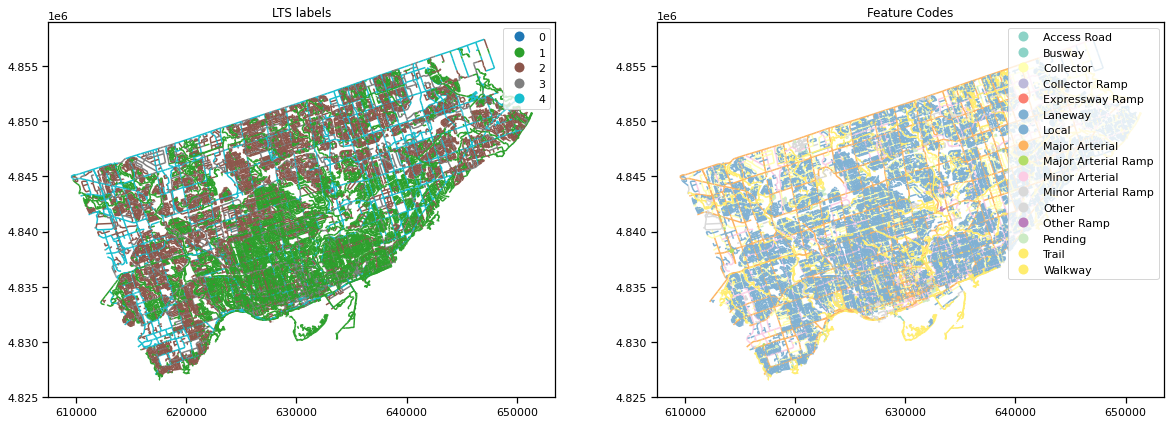

In [51]:
#Plot the LTS and feature descriptions to ensure the merge worked
fig, axs = plt.subplots(figsize=(20,12), ncols=2, nrows=1)

# Plotting
centre_merge.plot(ax=axs[0], column=centre_merge['LTS str'], legend=True)
centre_merge.plot(ax=axs[1], column='FEATURE_CODE_DESC', legend=True, cmap='Set3')

# Attributes
axs[0].title.set_text('LTS labels')
axs[1].title.set_text('Feature Codes')

fig.savefig('Features and LTS')

#### Look for statistical relationships, breakdown the feature codes in the dataframe.
It looks like from the graph that we can easily group some feature codes together with others <br>
##### NOTE!!! we actually probably don't want to use the feature code descriptions, as they contain info that is used in determining LTS (data leakage)
https://journals.sagepub.com/doi/pdf/10.3141/2587-06 see the original paper that describes how to determine LTS. We don't want to use any of this stuff, or at least it if we have the data it should be part of a PCA that determines which are the most important features in classification of LTS. <br>
https://www.toronto.ca/wp-content/uploads/2018/01/950a-Road-Classification_Summary-Document.pdf how Toronto classifies roads

In [52]:
centre_merge['high access'] = centre_merge['LTS'].apply(lambda x: 1 if x <= 2 else 0)
centre_merge = centre_merge[centre_merge['LTS'] != 0]

In [53]:
centre_merge.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 59553 entries, 0 to 59553
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   OBJECTID           59553 non-null  int64   
 1   GEO_ID             59553 non-null  int64   
 2   LFN_ID             59553 non-null  int64   
 3   LF_NAME            59553 non-null  object  
 4   FNODE              59553 non-null  int64   
 5   TNODE              59553 non-null  int64   
 6   ONE_WAY_DI         59553 non-null  int64   
 7   length_in_         59553 non-null  float64 
 8   GEO_ID_1           59553 non-null  int64   
 9   LTS                59553 non-null  int64   
 10  Shape_Leng         59553 non-null  float64 
 11  geometry_x         59553 non-null  geometry
 12  CENTRELINE_ID      58626 non-null  float64 
 13  FEATURE_CODE       58626 non-null  float64 
 14  FEATURE_CODE_DESC  58626 non-null  object  
 15  JURISDICTION       58626 non-null  object  
 

In [54]:
centre_merge['LTS'].unique()

array([1, 2, 3, 4], dtype=int64)

<AxesSubplot:>

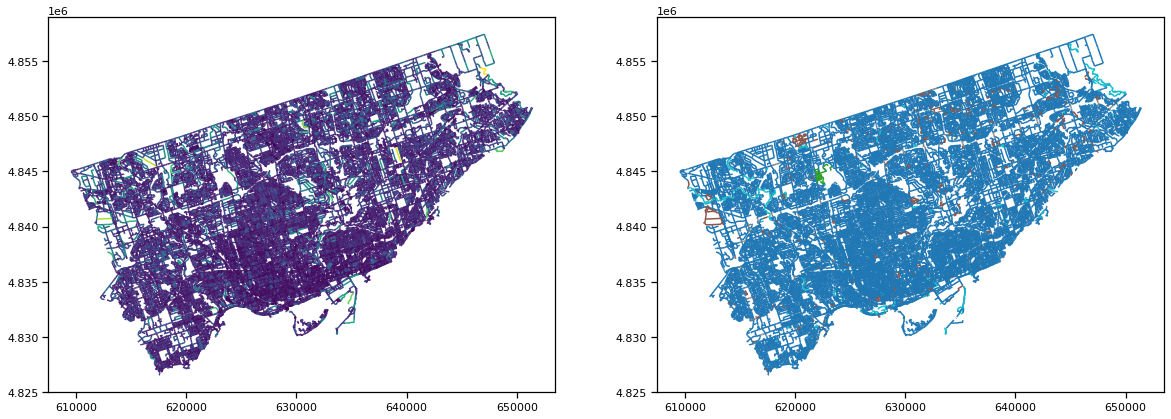

In [55]:
fig, axs = plt.subplots(figsize=(20,12), ncols=2, nrows=1)

# Plotting
centre_merge.plot(ax=axs[0], column='length_in_')
centre_merge.plot(ax=axs[1], column='JURISDICTION')

In [56]:
centre_merge = centre_merge.rename({'geometry_x':'geometry'}, axis=1)

Before test train splitting our data, we want to add the neighbourhood/k-mean cluster labels to the data so that spatial CV can be performed.

In [57]:
# Import the neighbourhood data and format it correctly.
fp_k, fp_k2 = 'C:/Users/Keagan Rankin/Documents/PycharmProj/data/raw_data/Neighbourhood Data/neighbourhood-profiles-2016-csv (1).csv', \
              'C:/Users/Keagan Rankin/Documents/PycharmProj/data/raw_data/Neighbourhood Data/Neighbourhoods.geojson'

neighbourhood_boundaries = gpd.read_file(fp_k2)
neighbourhood_metre = neighbourhood_boundaries.to_crs("EPSG:26917")
neighbourhood_metre = neighbourhood_metre[['geometry','AREA_ID']]



In [58]:
# Merge the two datasets, drop irrelevant information, fillnas if needed
centre_merge = gpd.sjoin(centre_merge, #left
                         neighbourhood_metre, #right
                         how='left',
                         op='within',
                        )

In [59]:
centre_merge['AREA_ID'] = centre_merge['AREA_ID'].fillna(101)
centre_merge = centre_merge.drop('index_right',axis=1)

test train split the data to go into the road_feature_model

In [61]:
# one last look
centre_merge.head()

,OBJECTID,GEO_ID,LFN_ID,LF_NAME,FNODE,TNODE,ONE_WAY_DI,length_in_,GEO_ID_1,LTS,...,geometry,CENTRELINE_ID,FEATURE_CODE,FEATURE_CODE_DESC,JURISDICTION,LINEAR_NAME_FULL,geometry_y,LTS str,high access,AREA_ID
0,1,30079678,19155,Waterfront Trl,30079676,30079656,0,457.224811,30079678,1,...,"LINESTRING (617480.231 4826902.149, 617480.138...",30079678.0,204001.0,Trail,CITY OF TORONTO,Waterfront Trl,"LINESTRING (617480.231 4826902.150, 617480.138...",1,1,101.0
1,2,30079680,19166,Marie Curtis Park Trl,30079676,30079679,0,35.226524,30079680,1,...,"LINESTRING (617480.231 4826902.149, 617476.262...",30079680.0,204001.0,Trail,CITY OF TORONTO,Marie Curtis Park Trl,"LINESTRING (617480.231 4826902.150, 617476.262...",1,1,2480159.0
2,3,30079677,19155,Waterfront Trl,30008708,30079676,0,37.170074,30079677,1,...,"LINESTRING (617498.783 4826933.578, 617490.916...",30079677.0,204001.0,Trail,CITY OF TORONTO,Waterfront Trl,"LINESTRING (617498.782 4826933.578, 617490.916...",1,1,2480159.0
3,4,30082310,10685,Island Rd,30008708,30082309,0,168.541328,30082310,1,...,"LINESTRING (617498.783 4826933.578, 617516.356...",30082310.0,201600.0,Other,PRIVATE,Island Rd,"LINESTRING (617498.782 4826933.578, 617516.356...",1,1,2480159.0
4,5,30008940,19155,Waterfront Trl,30008711,30008708,0,84.289210,30008940,1,...,"LINESTRING (617552.625 4826998.137, 617541.914...",30008940.0,204001.0,Trail,CITY OF TORONTO,Waterfront Trl,"LINESTRING (617552.626 4826998.138, 617541.915...",1,1,2480159.0


In [62]:
# Do a 80/20 test train split and save these to a csv
from sklearn.model_selection import train_test_split

#stratify the split across the LTS labels
train, test = train_test_split(centre_merge, test_size=0.2, stratify=centre_merge['LTS'])
print('Train:', train.shape, 'Test:', test.shape)
print('LTS 1 Train proportion: {:.2f} %'.format(train['LTS'][train['LTS'] == 1].shape[0] / train.shape[0] * 100))
print('LTS 1 Test proportion: {:.2f} %'.format(test['LTS'][test['LTS'] == 1].shape[0] / test.shape[0] * 100))

Train: (47642, 21) Test: (11911, 21)
LTS 1 Train proportion: 51.99 %
LTS 1 Test proportion: 51.99 %


In [63]:
train.to_csv('centreline_train_spatial.csv')
test.to_csv('centreline_test_spatial.csv')

 This could be a very useful alternative to the rigid classification methods from teh 2016 paper. <br>
 many cities in North America classify their roads into 4 or 5 common road types (Major Arterial, Minor Arterial, Collector, Local).
 according to TAC: https://www.toronto.ca/services-payments/streets-parking-transportation/traffic-management/road-classification-system/about-the-road-classification-system/ <br>
 For example: all of the municipalities in Quebec https://open.canada.ca/data/en/dataset/c937deb0-a089-4035-88f1-06b36bfd42c5 <br>
 Vancouver: https://opendata.vancouver.ca/explore/dataset/public-streets/map/?location=10,49.1826,-122.76535